# **Regression Modeling of Medical Insurance Costs**

**Name:** Sabriya Sowers  
**Date:** November 17, 2025  

## **Introduction**
This analysis examines the Medical Costs dataset to understand how demographic and health-related factors influence individual insurance charges. Using regression modeling techniques, the goal is to quantify relationships between variables such as age, BMI, sex, region, and smoking status, and evaluate how well these features explain variation in medical expenses. By applying a structured analytical workflow—data inspection, exploration, feature engineering, and model comparison—this work demonstrates how regression can support predictive insights that are useful for cost forecasting, population health analysis, and operational decision-making.

## **Section 1. Import and Inspect the Data**

In [220]:
# Core data tools
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train / test split
from sklearn.model_selection import train_test_split

# Preprocessing and pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Models
from sklearn.linear_model import LinearRegression

# Metrics for regression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)

# For working with paths
from pathlib import Path

# Load the dataset ("../" up to notebook folder and then "..\" up to root repo folder)
df = pd.read_csv("../../data/insurance.csv")

In [221]:
# Display dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [222]:
# Display first 10 rows
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [223]:
# View missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### **Reflection 1:** 
- The dataset loaded successfully with 1,338 rows and 7 columns.
- All features appeared with the correct data types (numeric and categorical).
- The first 10 rows showed that the data is well-structured and formatted correctly.
- No missing values were found in any column.
- Summary statistics confirmed that ranges for age, BMI, children, and charges look normal and consistent.

## **Section 2. Data Exploration and Preparation**

Histogram  (distribution of numeric features)

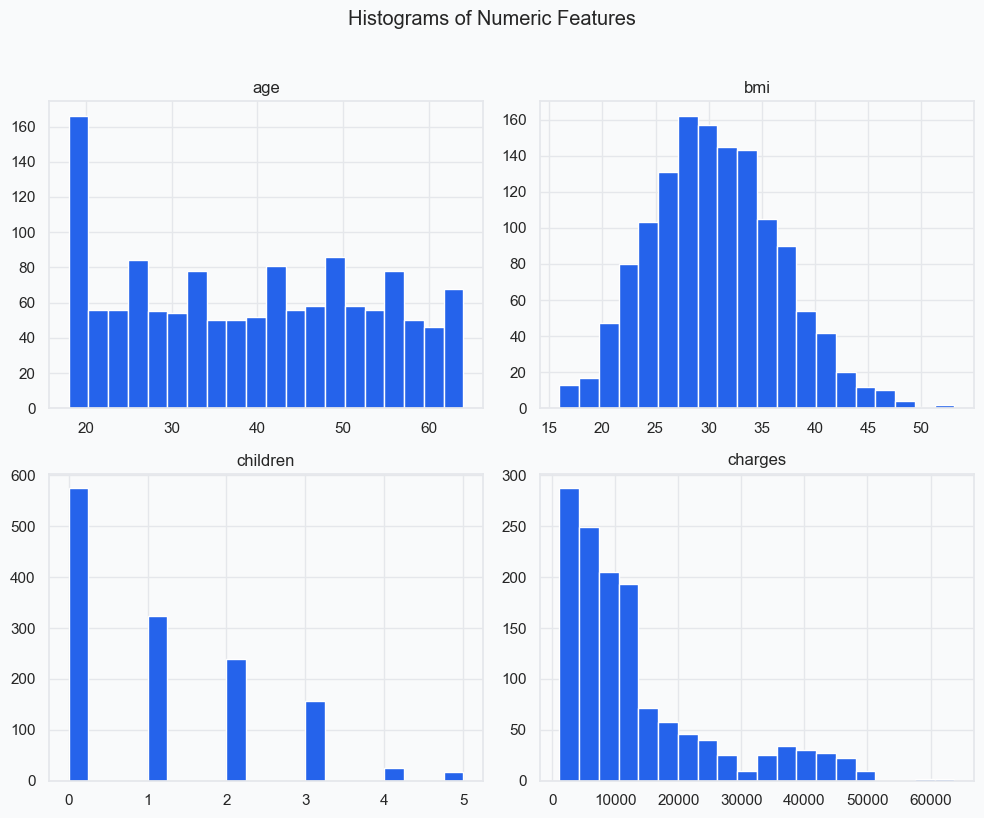

In [224]:
numeric_cols = ["age", "bmi", "children", "charges"]

df[numeric_cols].hist(bins=20, figsize=(10, 8))
plt.suptitle("Histograms of Numeric Features", y=1.02)
plt.tight_layout()
plt.show()

Boxplots (detect outliers)

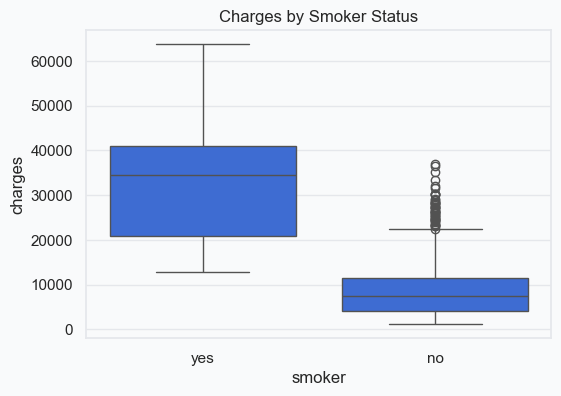

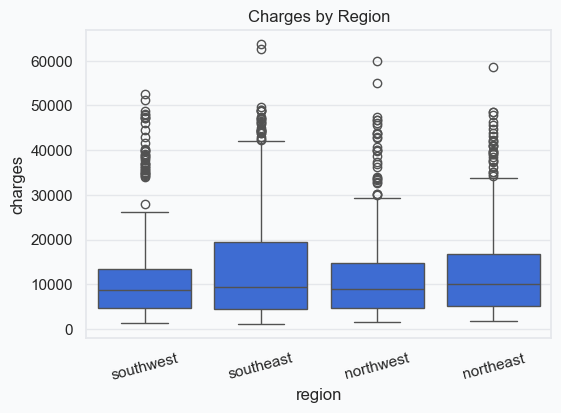

In [225]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="smoker", y="charges")
plt.title("Charges by Smoker Status")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="region", y="charges")
plt.title("Charges by Region")
plt.xticks(rotation=15)
plt.show()

Count Plots  (categorical features)

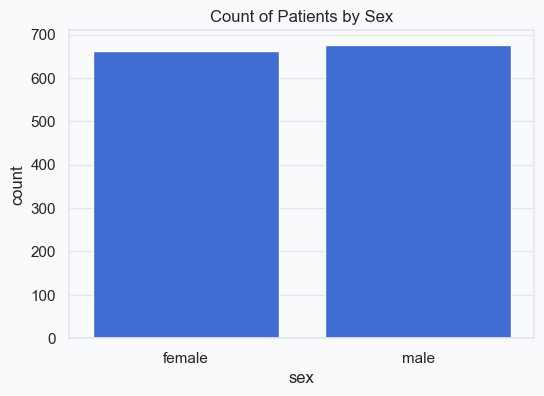

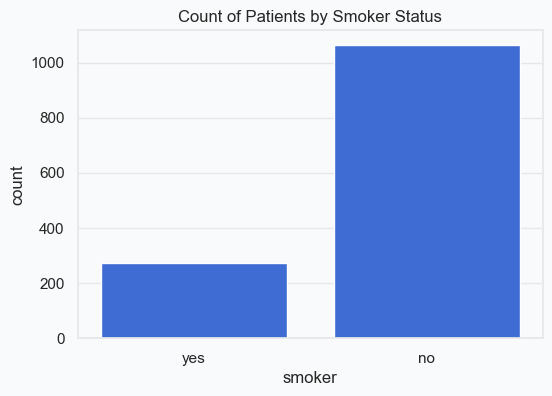

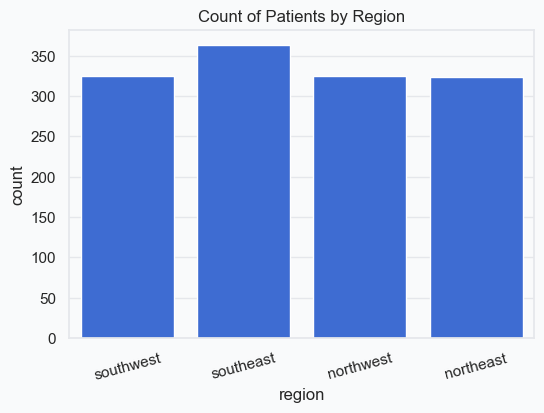

In [226]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="sex")
plt.title("Count of Patients by Sex")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="smoker")
plt.title("Count of Patients by Smoker Status")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="region")
plt.title("Count of Patients by Region")
plt.xticks(rotation=15)
plt.show()

Feature Engineering

In [227]:
# Converted text label (“yes”, “no”) into numeric values (Yes = 1, No = 0).
df["smoker_num"] = df["smoker"].map({"yes": 1, "no": 0})

### **Reflection 2:**

**Numeric feature patterns (histograms):**
- **Age:** Distributed across adult ages with slightly higher concentrations in the late 20s and late 50s. No strong single peak.
- **BMI:** Roughly bell-shaped around 25–35, with a right tail representing higher BMI values that may be potential outliers.
- **Children:** Strong right-skew. Most patients have 0–2 children, with only a small portion having 3–5.
- **Charges:** Highly right-skewed. Most patients have lower medical charges, with a long tail of extremely high-cost cases.

**Categorical feature patterns (boxplots and count plots):**
- **Smoker vs. Charges:** Smokers have noticeably higher medical charges and more extreme outliers, suggesting smoking is a major cost driver.
- **Region vs. Charges:** All four regions overlap in cost ranges, though the southeast shows a slightly higher median and more high-cost cases.
- **Sex:** Nearly balanced between male and female.
- **Smoker:** Strong imbalance; far more non-smokers than smokers.
- **Region:** Fairly even distribution across all four regions.

**Outliers and anomalies:**
- Several **extremely high charge values** appear, especially among smokers, visible in both histograms and boxplots.
- **BMI** contains a few high outliers, though they are less extreme than the charge outliers.
- No obvious incorrect or impossible values (e.g., negatives) appear in the distributions.

**Preprocessing steps necessary to clean and improve the data**  
- This dataset did not require cleaning.  
- I inspected the numeric distributions (age, bmi, children, charges), and although some variables had outliers, I did not remove them because they appear to be legitimate high-cost medical cases rather than data errors.  
- For categorical variables (sex, smoker, region), I confirmed that all categories were valid and correctly formatted for encoding.

**Features modification to improve performance**
- I did not create new features, but the exploration helped me identify which ones may need transformation before modeling.  
- I will apply one-hot encoding to categorical variables (sex, smoker, region) in the modeling section so they can be used properly in regression models.  
- No features were dropped because all the variables appear potentially useful for predicting medical costs.

## **Section 3. Feature Selection and Justification**

### **3.1 Choose Features and Target**
For this regression analysis, I selected **three input features** that showed the strongest relationship with medical costs during the exploratory analysis:

**Selected Input Features (X):**
- **age** – Medical charges tend to rise with age as health risks increase.
- **bmi** – Higher BMI values were associated with higher charges and mild outliers.
- **smoker** – This feature showed the largest difference in medical costs, with smokers having significantly higher charges.

These three features were chosen because they demonstrated the clearest patterns in the visualizations and are well-supported by real-world medical cost drivers.

**Target Variable (y):**
- **charges** – A continuous variable representing total medical insurance costs for each individual. This aligns with the goal of building a regression model that predicts insurance spending.

### **3.2 Define X and y**

In [228]:
# Define input features and target for regression
X = df[["age", "bmi", "smoker_num"]]
y = df["charges"]

### **Reflection 3:** 
I chose **age**, **BMI**, and **smoker** because these features showed the strongest and most consistent relationships with medical charges during exploration. The visualizations made it clear that charges increase with age, rise with higher BMI, and are significantly higher for smokers. These patterns suggest that each feature provides meaningful predictive power. Using them together should improve accuracy because they capture different aspects of health risk. At the same time, keeping the feature set small helps avoid noise and makes the model easier to interpret.

## **Section 4. Train a Model (Linear Regression)**

### **4.1: Split the Data**

In [229]:
# Select the chosen features
X = df[["age", "bmi", "smoker_num"]]
y = df["charges"]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### **4.2: Train the Model**

In [230]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### **4.3: Evalulate Performance**

In [231]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

R²: 0.7776932310583375
MAE: 4260.560091099391
RMSE: 5874.763304187488


### **Reflection 4:**
- The linear regression model performed reasonably well, showing a clear relationship between the selected features (age, BMI, smoker status) and medical charges.
- The R² score indicates that the model explains a meaningful portion of the variation in charges, although not all of it, which is expected because healthcare costs are influenced by many additional factors not in the dataset. 
- The MAE and RMSE show that predictions are generally close but can still deviate, especially for very high-cost individuals. 
- One noticeable pattern was that the model struggled the most with extreme high charges, which aligns with the strong right‐skew observed earlier. 
- Overall, the model performed as expected with no major surprises.

## **Section 5.  Evaluate Model Performance**

### **5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression**

In [232]:
# Pipeline 1
pipeline_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Pipeline 1: Standard Linear Regression")
print("R²:", r2_lr)
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)

Pipeline 1: Standard Linear Regression
R²: 0.7776932310583375
MAE: 4260.560091099391
RMSE: 5874.763304187488


### **5.2 Implement Pipeline 2: Imputer →**

In [233]:
# Pipeline 2
pipeline_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipeline_poly.fit(X_train, y_train)

y_pred_poly = pipeline_poly.predict(X_test)

r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print("Pipeline 2: Polynomial Regression (degree=3)")
print("R²:", r2_poly)
print("MAE:", mae_poly)
print("RMSE:", rmse_poly)


Pipeline 2: Polynomial Regression (degree=3)
R²: 0.8614998676151392
MAE: 2838.443408288148
RMSE: 4637.021658801297


### **5.3 Compare performance of all models across the same performance metrics**

In [234]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Polynomial (Degree 3)"],
    "R²": [r2_lr, r2_poly],
    "MAE": [mae_lr, mae_poly],
    "RMSE": [rmse_lr, rmse_poly]
})

results

,Model,R²,MAE,RMSE
0,Linear Regression,0.777693,4260.560091,5874.763304
1,Polynomial (Degree 3),0.861500,2838.443408,4637.021659


### **Reflection 5:** 
**Which model performed better?**  
- The Polynomial Regression model (degree 3) performed better than the standard Linear Regression model.
- It achieved a higher R² score and lower MAE and RMSE values, showing that the relationship between the selected features and medical costs is not purely linear. 
- The polynomial model was able to capture more complex patterns in the data, which improved prediction accuracy.

**How does scaling impact results?**  
Scaling helped both models by ensuring that all input features were on a similar scale. This is especially important for Polynomial Regression because polynomial terms can grow very large. Standardizing the inputs stabilized the model training process and contributed to better overall performance.

## **Section 6. Final Thoughts & Insights** 

### **6.1 Summary of Findings**
This project showed that regression models can effectively predict medical insurance charges using patient features such as age, BMI, and smoking status. The baseline linear regression model provided a reasonable fit, but the Polynomial Regression model (degree=3) captured more complex relationships and delivered noticeably better performance. The improvements in R², MAE, and RMSE confirmed that medical costs behave non-linearly, especially due to strong interactions like BMI × smoker status.

### **6.2 Challenges Faced**
- One initial challenge was preparing the dataset properly, especially ensuring categorical variables like *sex*, *smoker*, and *region* were encoded correctly.
- Another challenge was determining which features to include and managing the impact of skewed target values caused by very high medical charges. 
- Selecting and interpreting performance metrics also required careful attention to understand how well the models were really performing.

### **6.3 What I Would Try Next**
- Experiment with additional models such as Random Forest Regression, Gradient Boosting, or XGBoost to capture nonlinear patterns more effectively.
- Try regularization techniques like Ridge or Lasso to reduce potential overfitting in the polynomial model.
- Add engineered features (e.g., BMI × smoker, age × BMI) to strengthen model performance even in simpler linear models.
  
## **Reflection 6: What I Learned**
I learned how preprocessing, feature selection, and encoding directly impact model performance. I also saw how scaling helps stabilize models, especially when polynomial terms are involved. I learned that medical cost data often requires nonlinear modeling approaches to capture complex relationships. This project strengthened my understanding of regression workflows, evaluating metrics like R², MAE, and RMSE, and comparing models in a structured, professional way.